### Import Library

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skimage import io
from skimage.color import rgb2gray
from skimage.morphology import dilation, disk
from skimage.segmentation import find_boundaries
from IPython.display import Image, display

In [2]:
# 1. 구글 드라이브를 마운트합니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### zip 파일 해제

In [2]:
# 2. 압축된 zip 파일의 경로를 설정합니다.
zip_file_path = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/archive.zip'  # zip 파일의 경로를 지정하세요.
extracted_folder_path = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset'  # 압축 해제할 폴더 경로를 지정하세요.

# 3. zip 파일을 압축 해제합니다.
import zipfile
import os

# 압축 해제할 폴더가 없으면 생성합니다.
if not os.path.exists(extracted_folder_path):
    os.makedirs(extracted_folder_path)

# zip 파일을 엽니다.
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_folder_path)

print('압축 해제가 완료되었습니다.')

압축 해제가 완료되었습니다.


### data-analysis

In [3]:
df=pd.read_csv(r'/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/GroundTruth.csv')

In [12]:
# 데이터셋 구성
print(df.head())

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [11]:
# 총 데이터셋 수
print(len(df))

10015


In [13]:
# class label
print(df.columns)

Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [14]:
# 기본 통계 요약
print(df.describe())

                MEL            NV           BCC         AKIEC           BKL  \
count  10015.000000  10015.000000  10015.000000  10015.000000  10015.000000   
mean       0.111133      0.669496      0.051323      0.032651      0.109735   
std        0.314313      0.470418      0.220667      0.177730      0.312575   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        0.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 DF          VASC  
count  10015.000000  10015.000000  
mean       0.011483      0.014179  
std        0.106546      0.118233  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


In [15]:
# 각 클래스의 빈도 확인
class_counts = df.iloc[:, 1:].sum()
print(class_counts)

MEL      1113.0
NV       6705.0
BCC       514.0
AKIEC     327.0
BKL      1099.0
DF        115.0
VASC      142.0
dtype: float64


In [16]:
# 결측치 확인
missing_values = df.isnull().sum()
print(missing_values)

image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64


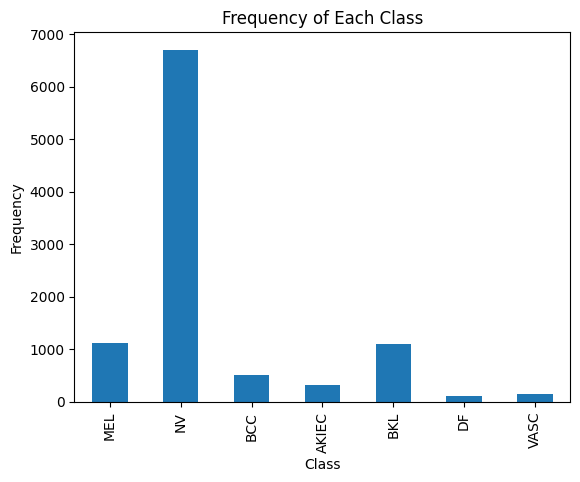

MEL      11.113330
NV       66.949576
BCC       5.132302
AKIEC     3.265102
BKL      10.973540
DF        1.148278
VASC      1.417873
dtype: float64


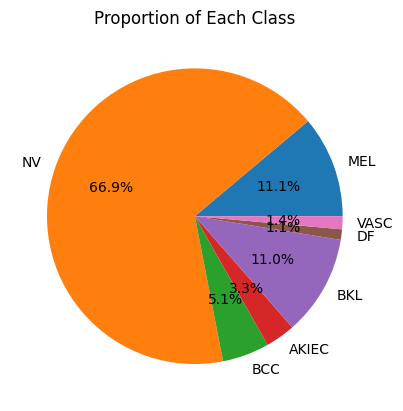

In [26]:
# 클래스별 분포 시각화 - 막대 바
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class')
plt.show()

# 클래스별 데이터 비율 확인
total_images = len(df)
class_proportions = class_counts / total_images * 100
print(class_proportions)

# 시각화 - 파이 그래프
class_proportions.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Proportion of Each Class')
plt.show()

num_classes
1.0    10015
Name: count, dtype: int64


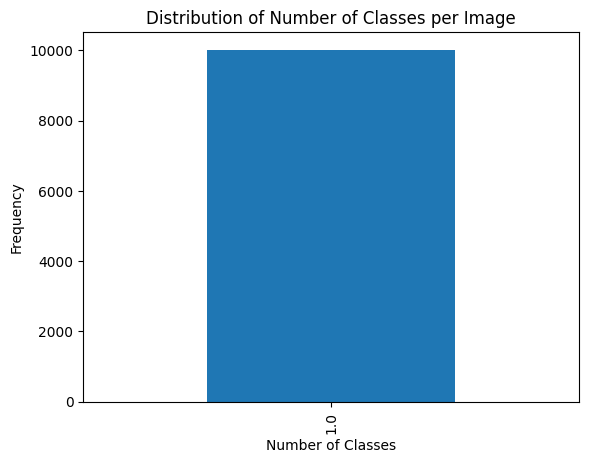

In [32]:
# 각 이미지가 속하는 클래스 수 확인
df['num_classes'] = df.iloc[:, 1:].sum(axis=1)

# 다중 클래스 분포 확인
class_distribution = df['num_classes'].value_counts()
print(class_distribution)

# 시각화
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar')
plt.xlabel('Number of Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Classes per Image')
plt.show()


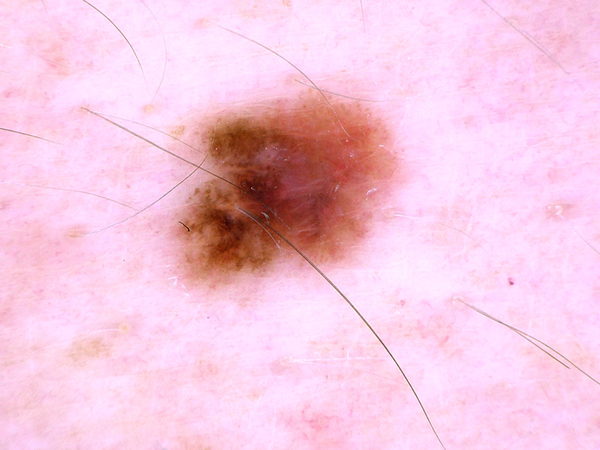

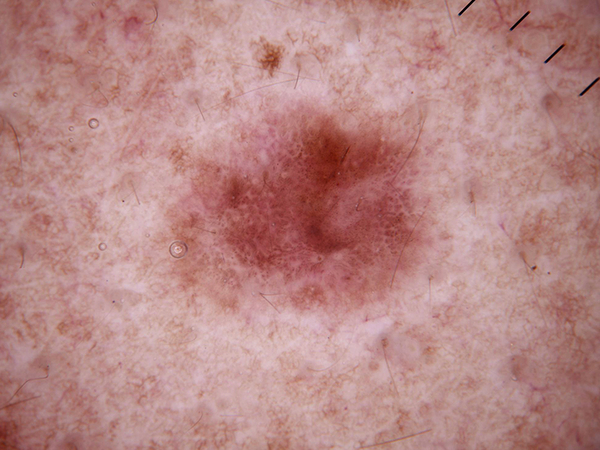

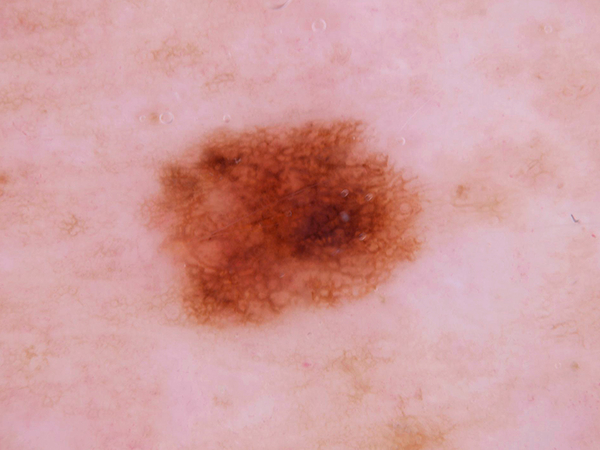

In [21]:
# 각 클래스별 이미지 샘플 확인

def display_sample_images(class_name, n=3):
    sample_images = df[df[class_name] == 1].sample(n)['image'].tolist()
    for image_id in sample_images:
        display(Image(filename=f'/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/images/{image_id}.jpg'))

# 예시: MEL 클래스 이미지 3개 표시
display_sample_images('MEL', 3)

### original images & mask images

In [4]:
# 데이터프레임 로드
df = pd.read_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/GroundTruth.csv')

# 이미지 경로 설정
image_dir = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/images'
mask_dir = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/masks'

In [15]:
def visualize_segmentation(image_path, mask_path, boundary_thickness=3):
    # 이미지와 마스크 로드
    image = io.imread(image_path)
    mask = io.imread(mask_path, as_gray=True)

    # 경계선 찾기
    boundaries = find_boundaries(mask, mode='inner')

    # 경계선 굵게 하기
    boundaries_dilated = dilation(boundaries, disk(boundary_thickness))

    # 경계선 색깔 지정
    boundary_color = [255, 0, 0]  # Red
    image_with_boundaries = image.copy()
    for c in range(3):  # R, G, B 채널 각각에 대해 경계선 적용
        image_with_boundaries[boundaries_dilated, c] = boundary_color[c]

    # 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_boundaries)
    plt.axis('off')
    plt.show()

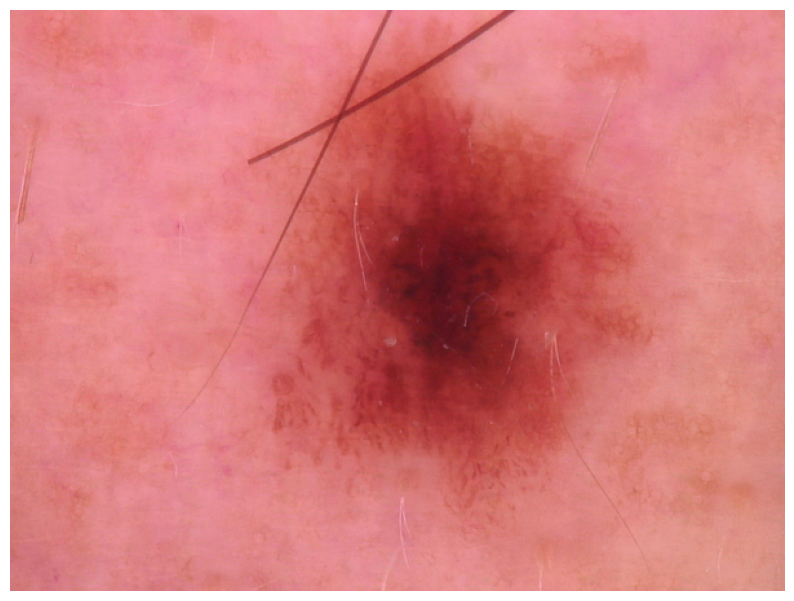

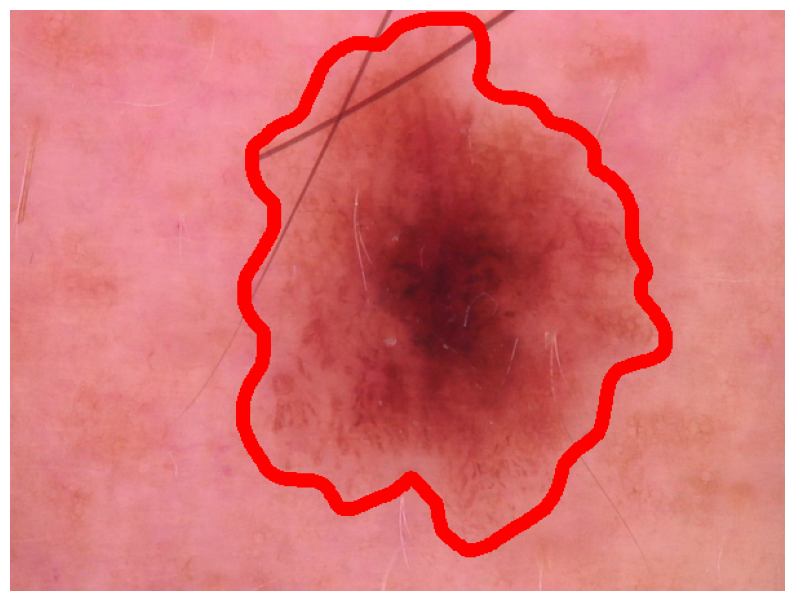

In [16]:
# 예시 이미지 선택
example_image = df['image'].iloc[0]
image_path = os.path.join(image_dir, f'{example_image}.jpg')
mask_path = os.path.join(mask_dir, f'{example_image}_segmentation.png')

# 시각화 함수 실행
visualize_segmentation(image_path, mask_path, boundary_thickness=5)